In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

from src.utils.utils_fn import *
from config.config import settings
import pandas as pd
import joblib
import json
import toml

import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# Lectura del dataset
data_path = settings.DATA_DIR / 'processed/data_processed.parquet'
data = pd.read_parquet(path=str(data_path))

# Setear los ids como índices
data: pd.DataFrame = data.set_index('product_id')
data.sample(5, random_state=10)

,condition,state,city,local_pickup,free_shipping,shipping_mode,listing_type,buying_mode,attribute_group_id,attribute_group,...,status,accepts_mercadopago,currency,automatic_relist,title,stock_quantity,available_quantity,total_amount,date_difference_hr,time_difference_hr
product_id,,,,,,,,,,,,,,,,,,,,,
mla5501620002,used,capital federal,nuñez,True,False,not_specified,bronze,buy_it_now,None,None,...,active,True,ars,False,timbre inahalambrico,1,1,0.0,0.000833,1440.0
mla2357269269,used,buenos aires,avellaneda,True,False,not_specified,bronze,buy_it_now,dflt,otros,...,active,True,ars,False,lote de 2 cinturones. 1 nuevo con etiqueta.mic...,8,8,0.0,695.485278,1440.0
mla4505955642,used,buenos aires,acassuso,True,False,me2,bronze,buy_it_now,None,None,...,active,True,ars,False,revista instituto de historia del derecho rica...,3,3,0.0,0.000833,1440.0
mla7853937105,used,capital federal,retiro,True,False,not_specified,free,buy_it_now,None,None,...,active,True,ars,False,susan sontag - la enfermedad y sus metaforas -...,1,1,0.0,0.000833,1440.0
mla7813601724,new,capital federal,almagro,True,False,not_specified,silver,buy_it_now,None,None,...,active,True,ars,False,vendas cambric marca vendsur de 10cm x 3mt en ...,7,7,2010.0,0.000556,1440.0


In [3]:
# Separación de los conjuntos de datos
# =====================================================================================
from sklearn.model_selection import train_test_split

# Inicializar una semilla
SEED = 25

# Separamos los features y el target
X = data.loc[:, data.columns != 'condition'] # type: ignore
y = data.loc[:, data.columns == 'condition'].squeeze() # type: ignore

# Verificar que los índices coinciden
assert (X.index == y.index).all(), 'Los índices de X e y no coinciden'

# Dividir el conjunto original en 70% entrenamiento y 30% para pruebas y validación
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.4, 
    random_state=SEED, 
    stratify=y
)

# Luego, dividir el 30% restante en 20% para validación y 10% para pruebas
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=1/2, 
    random_state=SEED, 
    stratify=y_temp
)

# Categóricas
X_train['local_pickup'] = X_train['local_pickup'].astype('category')
X_val['local_pickup'] = X_val['local_pickup'].astype('category')
X_test['local_pickup'] = X_test['local_pickup'].astype('category')

In [4]:
from sklearn.preprocessing import LabelEncoder

# Codificación del target
le = LabelEncoder()
y_train = pd.Series(le.fit_transform(y_train), index=y_train.index)
y_val = pd.Series(le.transform(y_val), index=y_val.index)
y_test = pd.Series(le.transform(y_test), index=y_test.index)

In [6]:
from sklearn.pipeline import Pipeline

# Pipeline de procesamiento
pipe_feature_selection = joblib.load(f'{settings.ART_DIR}/pipelines/pipeline_feature_selection.pkl')
pipe_feature_engineering = joblib.load(f'{settings.ART_DIR}/pipelines/pipeline_feature_engineering.pkl')
pipe = Pipeline([
    ('feature_selection', pipe_feature_selection),
    ('feature_engineering', pipe_feature_engineering)
])

print(pipe.get_params())

{'memory': None, 'steps': [('feature_selection', Pipeline(steps=[('drop-features',
                 DropFeatures(features_to_drop=['attribute_group_id',
                                                'attribute_group',
                                                'attribute_id', 'title',
                                                'city'])),
                ('constant-features',
                 DropConstantFeatures(missing_values='ignore', tol=0.95,
                                      variables=['stock_quantity',
                                                 'available_quantity',
                                                 'total_amount',
                                                 'date_difference_hr',
                                                 'time_difference_hr', 'state',
                                                 'local_pickup',
                                                 'free_ship...
                                                 'listi

In [7]:
# Ejecución
pipe.fit(X_train, y_train)
X_train = pipe.transform(X_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(X_test)

In [9]:
import xgboost as xgb

# Crear un objeto Booster vacío
model = xgb.Booster()

# Cargar el modelo desde un archivo JSON
model.load_model(f'{settings.ART_DIR}/final_model.json')

In [12]:
from sklearn.metrics import roc_auc_score, log_loss

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

train_preds = model.predict(dtrain)
val_preds  = model.predict(dval)
test_preds  = model.predict(dtest)

# Calcular las métricas
train_auc = roc_auc_score(y_train, train_preds)
train_logloss = log_loss(y_train, train_preds)

val_auc = roc_auc_score(y_val, val_preds)
val_logloss = log_loss(y_val, val_preds)

test_auc = roc_auc_score(y_test, test_preds)
test_logloss = log_loss(y_test, test_preds)

print(f'Train AUC: {train_auc:.4f}, Train Log-loss: {train_logloss:.4f}')
print(f'Val AUC: {val_auc:.4f}, Val Log-loss: {val_logloss:.4f}')
print(f'Test AUC: {test_auc:.4f}, Test Log-loss: {test_logloss:.4f}')

Train AUC: 0.8769, Train Log-loss: 0.4240
Val AUC: 0.8739, Val Log-loss: 0.4269
Test AUC: 0.8725, Test Log-loss: 0.4313


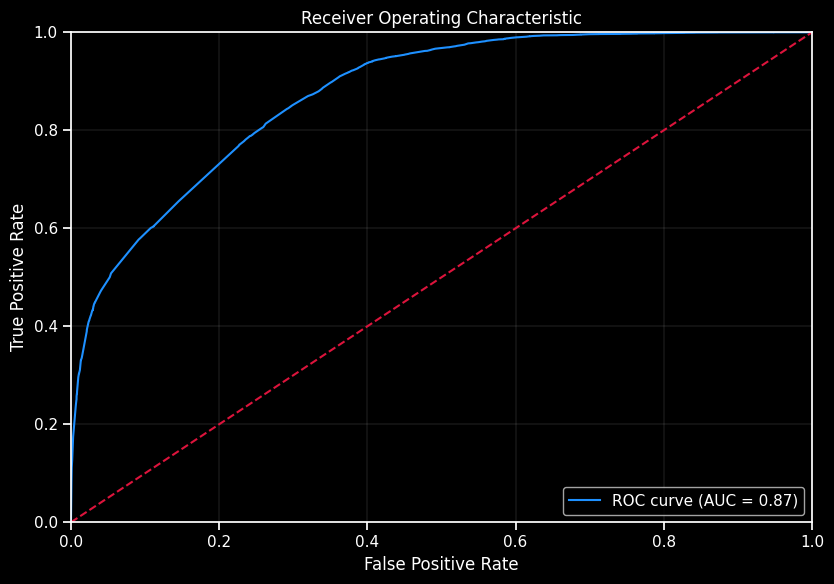

In [13]:
# Curva ROC con el modelo de línea base
roc_curve_plot(model, X_val, y_val)

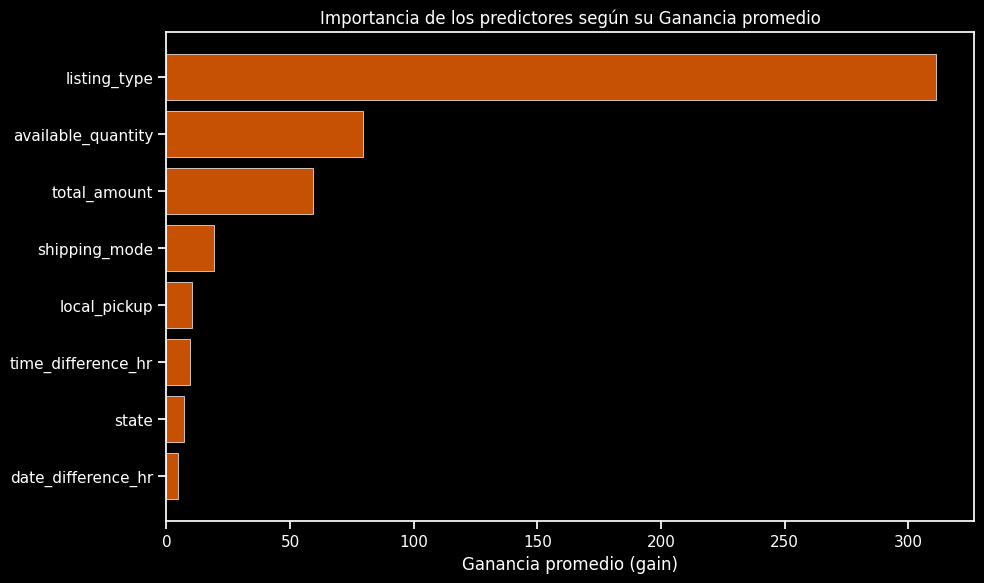

In [14]:
# Convertir el diccionario a listas para graficar
scores = model.get_score(importance_type='gain')
features = list(scores.keys())
gains = list(scores.values())

# Ordenar de mayor a menor
sorted_idx = np.argsort(gains)[::-1]
features_sorted = [features[i] for i in sorted_idx]
gains_sorted = [gains[i] for i in sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(features_sorted, gains_sorted, color='xkcd:dark orange', edgecolor='white', lw=0.5)
plt.xlabel('Ganancia promedio (gain)')
plt.title('Importancia de los predictores según su Ganancia promedio')
plt.gca().invert_yaxis()  # Para que la característica más importante esté en la parte superior
plt.tight_layout()

### Interpretación de la gráfica de importancia de variables

1. **listing_type**  
   - Es la variable más influyente. El “tipo de anuncio” (p. ej. *free*, *gold*) parece estar fuertemente ligado a que un artículo sea *nuevo* o *usado*, posiblemente porque ciertos planes de publicación resultan más atractivos o frecuentes para artículos nuevos.

2. **available_quantity**  
   - La cantidad de stock disponible también es muy determinante: los productos nuevos suelen publicarse con mayor inventario, mientras que los usados tienden a tener un stock limitado.

3. **total_amount**  
   - Refleja el valor total (precio, a veces multiplicado por cantidad). Los productos nuevos suelen tener precios mayores o ventas en mayor volumen, por lo que esta variable ayuda al modelo a distinguirlos de los usados.

4. **shipping_mode**  
   - El modo de envío (p. ej. *me2*, *not_specified*) influye, pues ciertos tipos de productos (nuevos vs. usados) suelen asociarse a opciones de envío más específicas.

5. **time_difference_hr / date_difference_hr**  
   - Representan la antigüedad o el tiempo transcurrido desde la creación/actualización del anuncio. Los usados pueden permanecer más tiempo publicados o tener distinta dinámica de actualización que los nuevos.

6. **local_pickup**  
   - Esta opción de retiro local puede estar más asociada a usados, ya que a menudo los vendedores de artículos usados prefieren la entrega personal o local.

7. **state**  
   - La ubicación (provincia/estado) aporta un contexto geográfico: en ciertas regiones predominan los productos nuevos, mientras que en otras pueden abundar los usados.

En resumen, el **modelo se apoya principalmente en el tipo de publicación, el inventario y el valor total** para identificar la condición del producto (nuevo vs. usado), mientras que **otras variables** (envío, tiempo, entrega local y ubicación) **aportan señales adicionales** que refuerzan la clasificación.


In [15]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Predicciones del modelo
# Obtener las probabilidades de clase 1
probs = model.predict(dtest)  # Probabilidad de que la muestra sea 1

# Calcular la probabilidad de clase 0
probs_0 = 1 - probs

# Definir un rango de thresholds a evaluar (por ejemplo, de 0.0 a 1.0 en pasos de 0.01)
thresholds = np.arange(0.0, 1.01, 0.01)

best_threshold = None
best_f1 = -np.inf

# Iterar sobre los thresholds y evaluar la métrica
for t in thresholds:
    preds = (probs >= t).astype(int)
    f1 = f1_score(y_test, preds,  average='macro')  # Puedes elegir otro promedio si lo deseas
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f'Threshold óptimo: {best_threshold} con Macro F1: {best_f1:0.2f}\n')

# Una vez obtenido el threshold óptimo, imprimir el reporte de clasificación
preds_opt = (probs >= best_threshold).astype(int)
print(classification_report(y_test, preds_opt))

Threshold óptimo: 0.52 con Macro F1: 0.77

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     10752
           1       0.74      0.79      0.76      9248

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.78      0.77      0.77     20000



In [16]:
# Predicciones del modelo
# Obtener las probabilidades de clase 1
probs = model.predict(dtest)  # Probabilidad de que la muestra sea 1

# Calcular la probabilidad de clase 0
probs_0 = 1 - probs

# Obtener la predicción binaria con un umbral de 0.5
preds = (probs >= best_threshold).astype(int)

# Crear el DataFrame con los resultados y reindexarlo con X_val.index
df = pd.DataFrame({
    'Probabilidad (Clase 0)': probs_0,
    'Probabilidad (Clase 1)': probs,
    'Predicción': preds
}, index=X_test.index)

# Mostrar una muestra aleatoria de 10 filas (para reproducibilidad se usa random_state)
df.sample(10, random_state=777)

,Probabilidad (Clase 0),Probabilidad (Clase 1),Predicción
product_id,,,
mla7606799186,0.063869,0.936131,1
mla6433005431,0.990753,0.009247,0
mla1606223490,0.448285,0.551715,1
mla1405842234,0.448285,0.551715,1
mla2315502624,0.063869,0.936131,1
mla3864860282,0.059560,0.940440,1
mla1699223605,0.054202,0.945798,1
mla5832104906,0.386723,0.613277,1
mla3967378072,0.386723,0.613277,1


In [17]:
# Etiquetas reales
y_test.sample(10, random_state=777)

product_id
mla7606799186    1
mla6433005431    0
mla1606223490    1
mla1405842234    1
mla2315502624    1
mla3864860282    1
mla1699223605    1
mla5832104906    1
mla3967378072    0
mla6630562752    0
dtype: int64

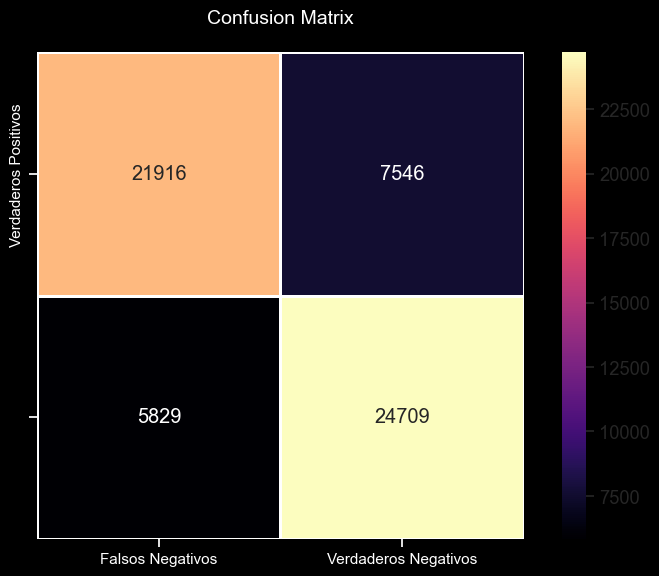

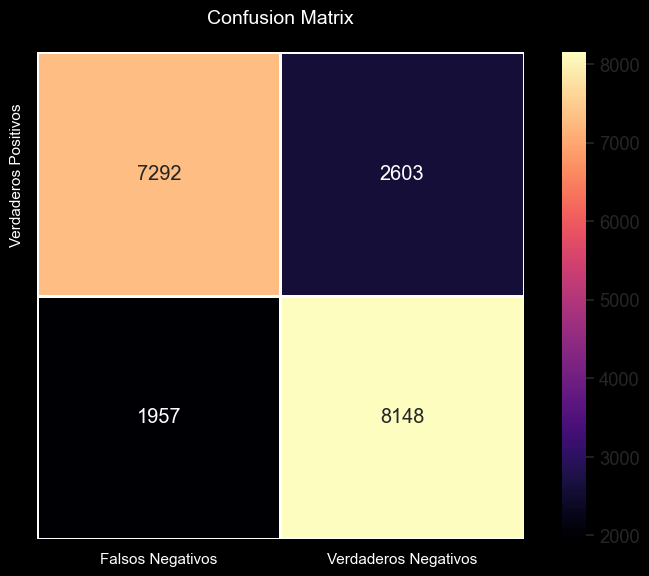

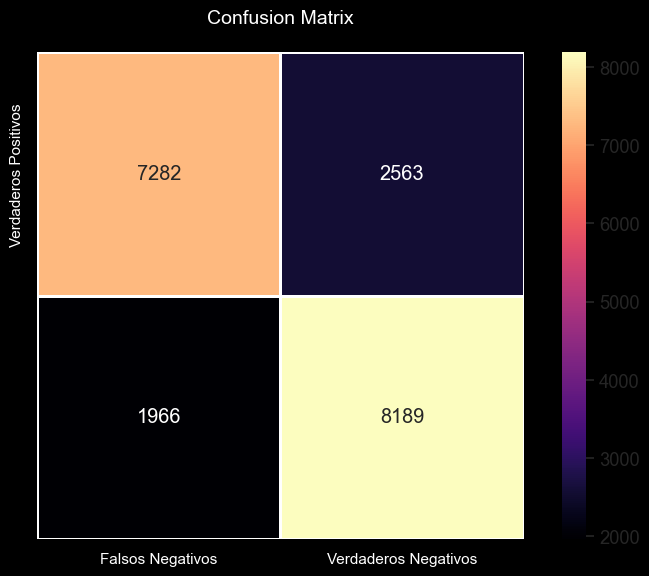

In [18]:
# Iterar sobre los conjuntos: para cada uno, obtener las predicciones y luego graficar la matriz de confusión
for set_name, ground_truth, dmatrix in [('Train', y_train, dtrain), ('Validation', y_val, dval), ('Test', y_test, dtest)]:
    preds = model.predict(dmatrix)  
    cnf_matrix(y_true=ground_truth, y_pred=preds, threshold=best_threshold)

### ¿Por qué importa esto al negocio?

- **Falsos Positivos** (clasificar algo usado como “nuevo”):
  - *Posible consecuencia*: El cliente recibe un producto que pensaba que era nuevo, pero en realidad es usado.
  - *Impacto de negocio*: Pueden surgir quejas, devoluciones y mala reputación por “engañar” al comprador. Además, puede haber costos logísticos asociados (procesar devoluciones, reembolsos, etc.).

- **Falsos Negativos** (clasificar algo nuevo como “usado”):
  - *Posible consecuencia*: Se subestima el valor de un producto.
  - *Impacto de negocio*: Vendes un artículo nuevo a precio de usado (pierdes margen de beneficio), o creas confusión en tu inventario y en la comunicación al cliente.

- **Verdaderos Positivos** (clasificar algo nuevo como “nuevo”)

- **Verdaderos Negativos** (clasificar algo usado como “usado”):
  - Estos representan los casos correctos en los que no hay fricción con el cliente ni pérdida económica por etiquetar bien el producto.